C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8393 - loss: 0.3700 - val_accuracy: 0.9109 - val_loss: 0.2295
Epoch 2/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9154 - loss: 0.2223 - val_accuracy: 0.9204 - val_loss: 0.2115
Epoch 3/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9292 - loss: 0.1952 - val_accuracy: 0.9334 - val_loss: 0.1763
Epoch 4/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9363 - loss: 0.1733 - val_accuracy: 0.9416 - val_loss: 0.1521
Epoch 5/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9450 - loss: 0.1499 - val_accuracy: 0.9501 - val_loss: 0.1329
Epoch 6/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9487 - loss: 0.1388 - val_accuracy: 0.9533 - val_loss: 0.1193
Epoch 7/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9529 - loss: 0.1240 - val_accuracy: 0.9620 - val_loss: 0.1011
Epoch 8/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9622 - loss: 0.1033 - 

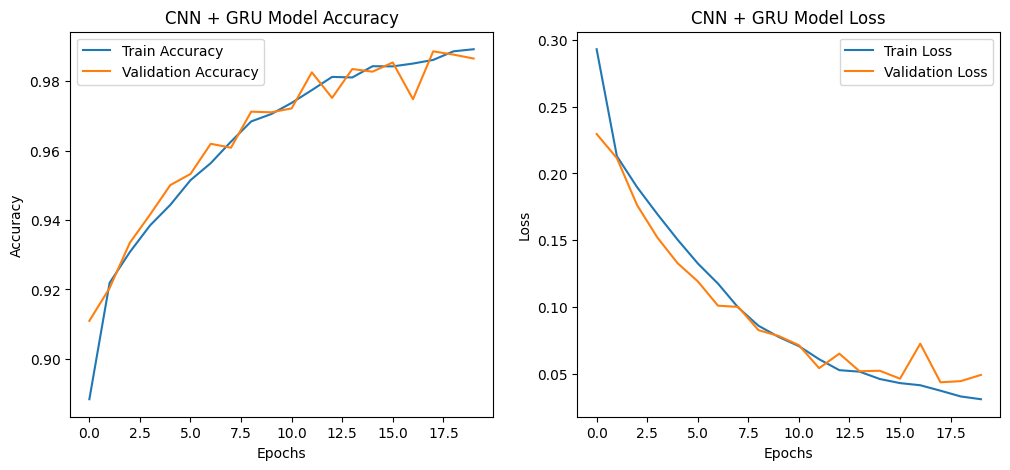

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


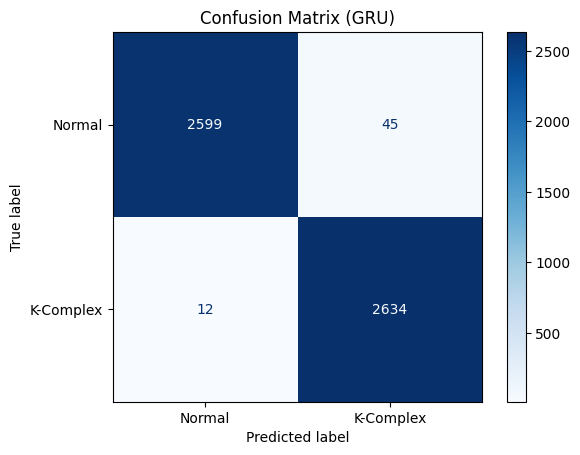

Classification Report (GRU):
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99      2644
   K-Complex       0.98      1.00      0.99      2646

    accuracy                           0.99      5290
   macro avg       0.99      0.99      0.99      5290
weighted avg       0.99      0.99      0.99      5290



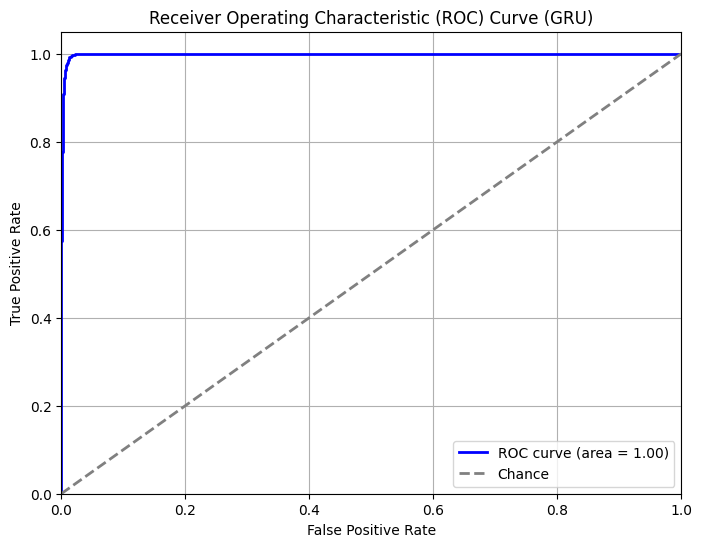

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GRU
import os
from tensorflow.keras.utils import to_categorical

# Path where all your files are stored
folder_path = 'D:/OneDrive_2024-12-27/Segmented by seperating spindles/Balanced_segmented/'

# Collect all Excel file paths in the folder
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.xlsx')]

# Initialize empty lists to store features and labels
X_list, y_list = [], []

# Load and combine data from all files
for file_path in file_paths:
    data = pd.read_excel(file_path)
    X_list.append(data.iloc[:, :-1].values)  # All columns except the last
    y_list.append(data.iloc[:, -1].values)  # The last column

# Concatenate data from all files
X = np.vstack(X_list)
y = np.hstack(y_list)

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for CNN (add a channel dimension)
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled_reshaped, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Convert labels to categorical format
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# Define the model with 1D CNN + GRU
model_gru = Sequential()

# First Conv1D layer
model_gru.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(200, 1)))
model_gru.add(MaxPooling1D(pool_size=2))

# Second Conv1D layer
model_gru.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model_gru.add(MaxPooling1D(pool_size=2))

# Add GRU layer
model_gru.add(GRU(64, return_sequences=False))
model_gru.add(Dropout(0.25))

# Flatten the result and add dense layers
model_gru.add(Flatten())
model_gru.add(Dense(128, activation='relu'))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(2, activation='softmax'))  # Output layer for binary classification

# Compile the model
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_gru = model_gru.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,  # You can adjust epochs as needed
    batch_size=32,
    verbose=1
)

# Evaluate the model
test_loss_gru, test_accuracy_gru = model_gru.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Loss (GRU): {test_loss_gru:.4f}")
print(f"Test Accuracy (GRU): {test_accuracy_gru:.4f}")

# Visualize training history (reuse your existing plotting code)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN + GRU Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('CNN + GRU Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion Matrix and Classification Report (reuse your existing code)
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Predict the classes for the test set
y_pred_gru = model_gru.predict(X_test)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)

# Generate the confusion matrix
conf_matrix_gru = confusion_matrix(y_test, y_pred_classes_gru)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gru, display_labels=['Normal', 'K-Complex'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (GRU)")
plt.show()

# Calculate precision, recall, and F1-score
report_gru = classification_report(y_test, y_pred_classes_gru, target_names=['Normal', 'K-Complex'])
print("Classification Report (GRU):")
print(report_gru)

# ROC curve and AUC (reuse your existing code)
from sklearn.metrics import roc_curve, auc

fpr_gru, tpr_gru, _ = roc_curve(y_test_cat[:, 1], y_pred_gru[:, 1])  # ROC for the positive class (K-Complex)
roc_auc_gru = auc(fpr_gru, tpr_gru)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gru, tpr_gru, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_gru:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (GRU)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
